<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Packages

In [311]:
#Google Big Query related packages
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time

from google.colab import drive
drive.mount('/content/drive')
#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

#ML Packages
from sklearn.preprocessing import RobustScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'CAS_ADS_Final_Project' already exists and is not an empty directory.


#Authenticate Google Big Query Access

In [299]:
auth.authenticate_user()
print('Authenticated')

Authenticated


##Connect to Big Query and Get Data

In [300]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` limit 10000;"
Query_Results = bigquery_client.query(Query)
df = Query_Results.to_dataframe()
df

#Copy Dataset
Data_Adf = df.copy()

#Account for Null Values
Data_Adf.replace('<NA>', np.nan, inplace=True)

In [301]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)



#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()


#Data Analysis

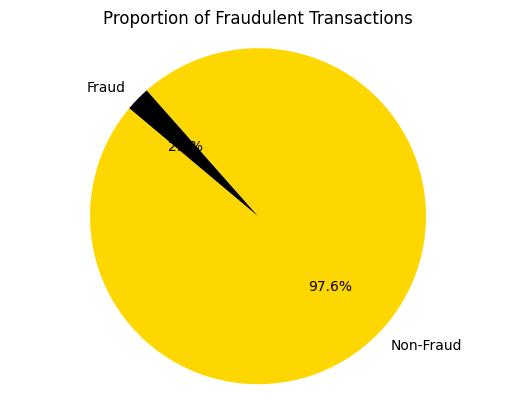

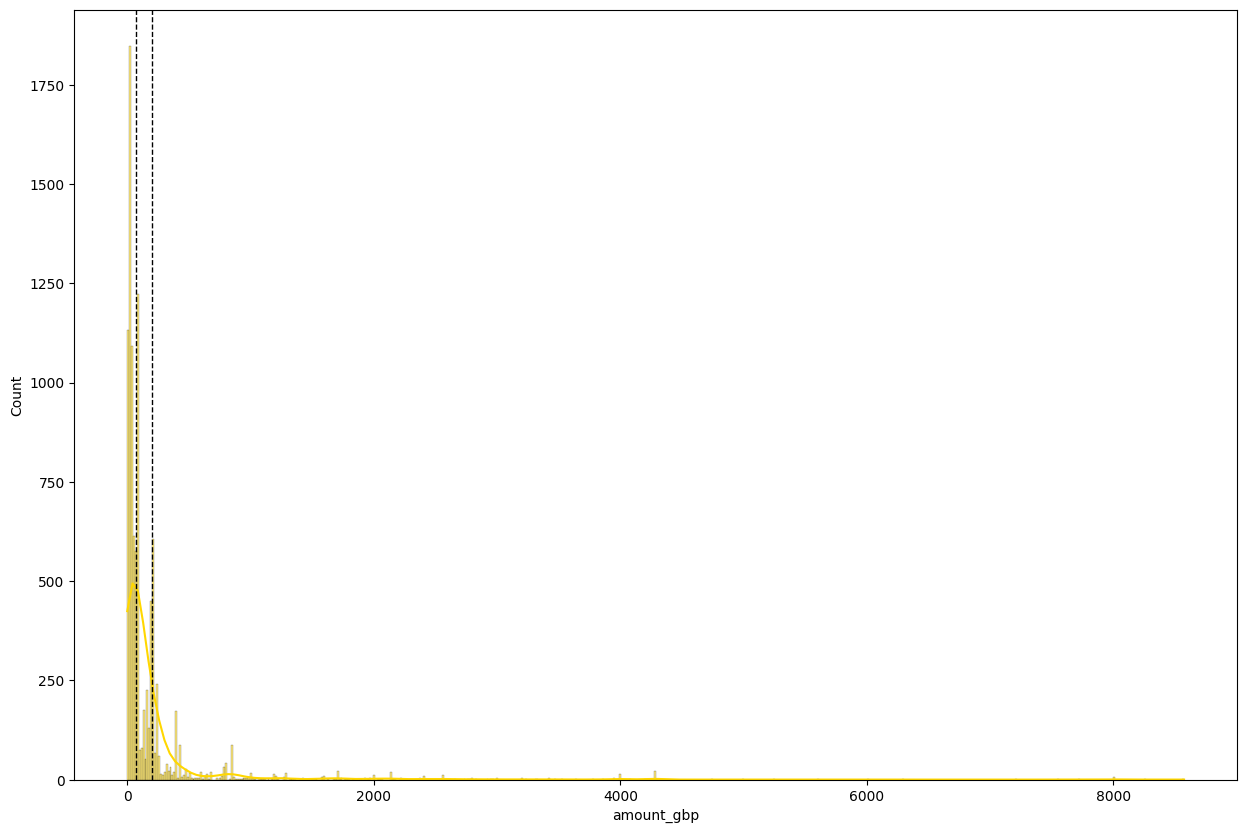

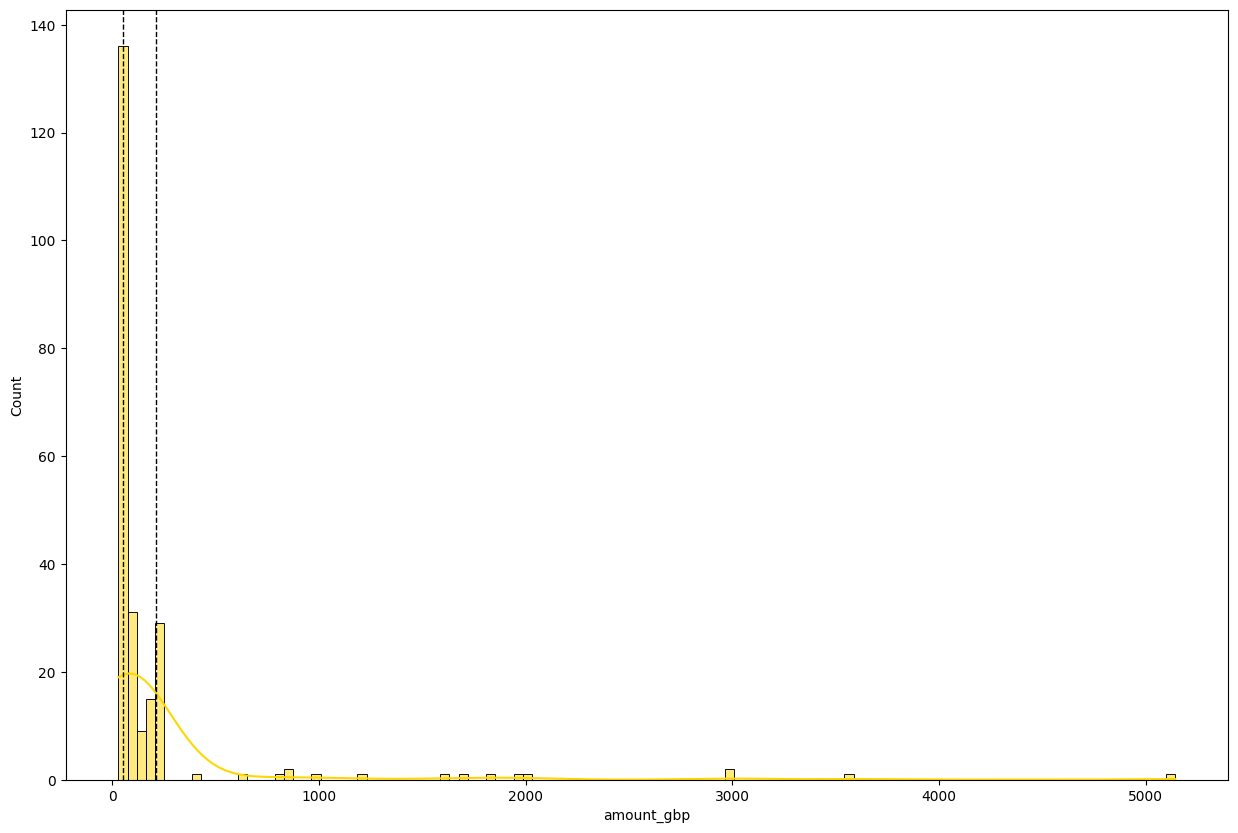

In [302]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [303]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge Datasets to one
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058611,37.64,37.64,1.0
1,1058623,37.64,37.64,1.0
2,1058646,77.67,77.67,1.0
3,1058647,237.83,237.83,1.0
4,1058815,37.64,37.64,1.0
...,...,...,...,...
9276,4640364,8.54,8.54,1.0
9277,4641269,80.07,80.07,1.0
9278,4641770,160.13,160.13,1.0
9279,4641887,67.46,67.46,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [304]:
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return None
    else:
        return None

df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')



#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]

old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile


#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,on='id')
merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns


old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
11392468,4564619,48.019573,66.923684,38.963745,35.243322
11492491,4604899,48.019573,66.923684,38.963745,35.243322
11516064,4614737,41.377491,64.585262,41.377491,64.585262
11406051,4570241,42.315407,43.356892,38.963745,35.243322
11416631,4506245,31.046051,34.851612,58.595272,25.013607
...,...,...,...,...,...
2532074,1352455,-22.957640,18.490410,-22.957640,18.490410
3079862,1519508,-22.957640,18.490410,-22.957640,18.490410
2491786,1339237,-22.957640,18.490410,-22.957640,18.490410


# Get Transaction Profile (Trx_Profile)

In [305]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)


columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
11392468,2024-04-09 12:31:03+00:00,4564619,80.07,45063,0,0
11492491,2024-04-19 15:24:28+00:00,4604899,80.07,55468,0,0
11516064,2024-04-22 14:04:00+00:00,4614737,80.07,50640,0,0
11406051,2024-04-10 15:26:04+00:00,4570241,80.07,55564,0,0
11416631,2024-04-11 14:32:22+00:00,4506245,0.80,52342,0,0
...,...,...,...,...,...,...
2532074,2021-03-25 09:16:39+00:00,1352455,53.65,33399,0,0
3079862,2021-06-24 08:07:49+00:00,1519508,45.10,29269,0,0
2491786,2021-03-17 11:32:53+00:00,1339237,37.64,41573,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [306]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 52.7 s, sys: 1.03 s, total: 53.8 s
Wall time: 53.5 s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1992727,2021-01-03 09:12:05,1058611,37.64,1.0,37.64,1.0,37.64,1.0,37.64
1983682,2021-01-01 03:39:00,1058623,37.64,1.0,37.64,1.0,37.64,1.0,37.64
1983736,2021-01-01 05:46:14,1058646,77.67,1.0,77.67,1.0,77.67,1.0,77.67
1983745,2021-01-01 05:59:56,1058647,237.83,1.0,237.83,1.0,237.83,1.0,237.83
1984446,2021-01-01 13:41:50,1058815,37.64,1.0,37.64,1.0,37.64,1.0,37.64
...,...,...,...,...,...,...,...,...,...
11582368,2024-04-30 08:49:20,4640364,8.54,1.0,8.54,1.0,8.54,1.0,8.54
11584822,2024-04-30 13:04:08,4641269,80.07,1.0,80.07,1.0,80.07,1.0,80.07
11586103,2024-04-30 14:59:26,4641770,160.13,1.0,160.13,1.0,160.13,1.0,160.13


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [307]:
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(bool)
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

Brand_Fraud_Profile.set_index('id')

Brand_Fraud_Profile

Brand_Fraud_Profile.set_index('id',inplace=True)

Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

Brand_Fraud_Profile

CPU times: user 1.14 s, sys: 11.7 ms, total: 1.15 s
Wall time: 1.15 s


,timestamp,Brands_id,amount_gbp_fraud_trx,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,,
1983682,2021-01-01 03:39:00,1234,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1983976,2021-01-01 09:09:44,1234,37.64,1.0,37.64,1.0,37.64,1.0,37.64
1993162,2021-01-03 12:37:40,1234,NaN,0.0,NaN,1.0,37.64,1.0,37.64
1993471,2021-01-03 14:51:51,1234,NaN,0.0,NaN,1.0,37.64,1.0,37.64
2090175,2021-01-06 15:24:59,1234,NaN,0.0,NaN,1.0,37.64,1.0,37.64
...,...,...,...,...,...,...,...,...,...
11289509,2024-03-30 17:26:12,851563,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11295819,2024-03-31 16:33:32,851563,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11557941,2024-04-27 08:09:42,851569,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Get All Dummy Variables (Data_Dummies)

In [308]:
# creating a copy of the original data frame and adding a few columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating all dummy variables
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_CZK,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_MYR,Currency_name_USD,Currency_name_ZAR,...,Companies_name_Zorafin_Investments_Ltd,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
11392468,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11492491,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11516064,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11406051,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11416631,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532074,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3079862,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2491786,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# Combine Everything to a Single Dataset

In [309]:
# Rest indexs in all dataframes in preparation to merge
Cust_Profiles #Key is Client id
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id
Data_Dummies = Data_Dummies.reset_index(level='id') #Key is id

#Merge all datasets to a single dataset
DF = pd.merge(Cust_Country_Profile, Trx_Profile, how='left', on='id')
DF1 = pd.merge(DF, Trx_Profile_Rolling,how='left',on='id')
DF2 = pd.merge(DF1, Brand_Fraud_Profile,how='left',on='id')
DF3 = pd.merge(DF2, Data_Dummies, how='left', on='id')
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Create New Dataframe
Pre_Norm_DF = DF4
#Gather columns containing Ids
column_ids = [col for col in Pre_Norm_DF.columns if '_id' in col]
column_ids.remove('Email_domain_idtech')
column_timestamp = [col for col in Pre_Norm_DF.columns if 'timestamp' in col]
columns_amount = [col for col in Pre_Norm_DF.columns if 'amount' in col]



dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

Pre_Norm_DF = Pre_Norm_DF.drop(columns = dropcolumns)
Pre_Norm_DF

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,48.019573,66.923684,38.963745,35.243322,45063,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,0,80.07,80.07,1.0
1,48.019573,66.923684,38.963745,35.243322,55468,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,0,80.07,80.07,1.0
2,41.377491,64.585262,41.377491,64.585262,50640,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,0,80.07,80.07,1.0
3,42.315407,43.356892,38.963745,35.243322,55564,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,0,80.07,80.07,1.0
4,31.046051,34.851612,58.595272,25.013607,52342,0,0,0.80,1.0,0.80,...,0,0,0,0,0,0,0,0.80,0.80,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-22.957640,18.490410,-22.957640,18.490410,33399,0,0,53.65,1.0,53.65,...,0,0,0,0,0,0,1,53.65,53.65,1.0
9996,-22.957640,18.490410,-22.957640,18.490410,29269,0,0,45.10,1.0,45.10,...,0,0,0,0,0,0,1,45.10,45.10,1.0
9997,-22.957640,18.490410,-22.957640,18.490410,41573,0,0,37.64,1.0,37.64,...,0,0,0,0,0,0,1,37.64,37.64,1.0
9998,-22.957640,18.490410,-22.957640,18.490410,66087,1,0,77.67,1.0,77.67,...,0,0,0,0,0,0,1,77.67,77.67,1.0


# Normalize Dataframe

In [312]:
#Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()
Normalized_DF = pd.DataFrame(scaler.fit_transform(Pre_Norm_DF), columns=Pre_Norm_DF.columns)

# Perform PCA